# SMF of NASA-Sloan Atlas

In [1]:
import os 
import h5py
import numpy as np 
# -- astrologs -- 
from astrologs.astrologs import Astrologs 
# -- galpopfm --
from galpopfm.catalogs import Catalog
# -- plotting --
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## read NSA catalog using `astrologs`

In [2]:
nsa_parent = Astrologs('nsa') 
nsa = Catalog('nsa')

## sample cuts
our nsa subsample has the following sample cuts 
- redshift limit
- footprint cut to simplify the comoving volume calculation
- absolute magnitude completeness limit ($M_r < -19.5$) 

(-30.0, 90.0)

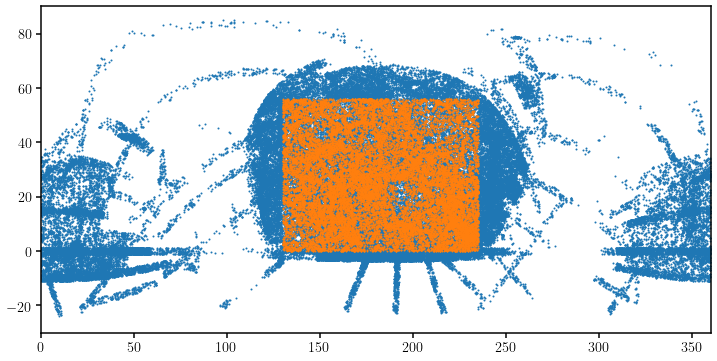

In [3]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(111)
sub.scatter(nsa_parent.data['ra'], nsa_parent.data['dec'], s=1)
sub.scatter(nsa.data['ra'], nsa.data['dec'], s=1)
sub.set_xlim(0., 360.)
sub.set_ylim(-30, 90.)

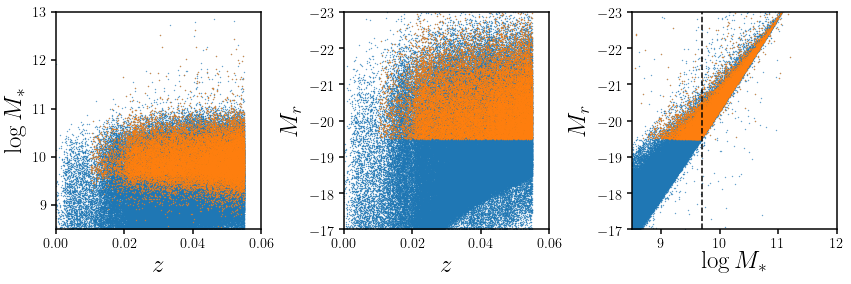

In [4]:
fig = plt.figure(figsize=(14,4))
sub = fig.add_subplot(131)
sub.scatter(nsa_parent.data['redshift'], nsa_parent.data['log.M_star'], s=0.1)
sub.scatter(nsa.data['redshift'], nsa.data['log.M_star'], s=0.1)
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_xlim(0., 0.06)
sub.set_ylabel(r'$\log M_*$', fontsize=25)
sub.set_ylim(8.5, 13.)

sub = fig.add_subplot(132)
sub.scatter(nsa_parent.data['redshift'], nsa_parent.data['M_r'], s=0.1)
sub.scatter(nsa.data['redshift'], nsa.data['M_r'], s=0.1)
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_xlim(0., 0.06)
sub.set_ylabel(r'$M_r$', fontsize=25)
sub.set_ylim(-17., -23)

sub = fig.add_subplot(133)
sub.scatter(nsa_parent.data['log.M_star'], nsa_parent.data['M_r'], s=0.1)
sub.scatter(nsa.data['log.M_star'], nsa.data['M_r'], s=0.1)
sub.plot([9.7, 9.7], [-17, -23], c='k', ls='--')
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(8.5, 12.)
sub.set_ylabel(r'$M_r$', fontsize=25)
sub.set_ylim(-17., -23)

fig.subplots_adjust(wspace=0.4)

## calculate NSA sample comoving volume

In [5]:
from astropy.cosmology import Planck13 as cosmo
print('%.1f (Mpc/h)^3' % ((cosmo.comoving_volume(0.055).value - cosmo.comoving_volume(0.01).value) * (56 * 105/41252.96) * cosmo.h**3))
vol_nsa = nsa.cosmic_volume
print('%.1f (Mpc/h)^3' % vol_nsa)

2558519.7 (Mpc/h)^3
2558519.7 (Mpc/h)^3


# calculate SMF

In [6]:
logms_bin = np.linspace(8., 13., 26)
dlogms = logms_bin[1:] - logms_bin[:-1]

In [7]:
Ngal_nsa, _ = np.histogram(nsa.data['log.M_star'], bins=logms_bin) 
phi_nsa = Ngal_nsa.astype(float) / vol_nsa / dlogms

(5e-05, 0.02)

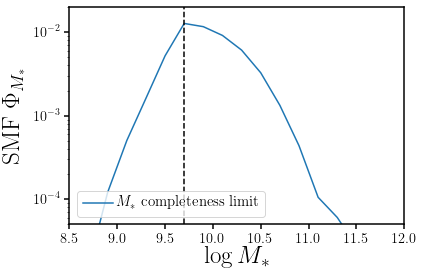

In [8]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(0.5*(logms_bin[1:] + logms_bin[:-1]), phi_nsa, label='$M_*$ completeness limit')
sub.legend(loc='lower left', frameon=True, handletextpad=0.2, fontsize=15)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(8.5, 12.)
sub.set_ylabel(r'SMF $\Phi_{M_*}$', fontsize=25)
sub.set_yscale("log")
sub.set_ylim(5e-5, 2e-2)
ylim = sub.get_ylim()
sub.plot([9.7, 9.7], ylim, c='k', ls='--')
sub.set_ylim(ylim)

Lets get some jackknife uncertainties on the SMF

In [9]:
jk_fields = [] 

ra_bins = np.linspace(130., 235., 5)
dec_bins = np.linspace(0., 56., 4)
for i in range(len(ra_bins)-1): 
    for j in range(len(dec_bins)-1): 
        infield = ((nsa.data['ra'] > ra_bins[i]) & (nsa.data['ra'] < ra_bins[i+1]) & 
                   (nsa.data['dec'] > dec_bins[j]) & (nsa.data['dec'] < dec_bins[j+1]))
        jk_fields.append(infield)

for i, field in enumerate(jk_fields): 
    print('field %i: %i' % (i, np.sum(field)))

field 0: 2105
field 1: 2210
field 2: 1873
field 3: 2347
field 4: 3038
field 5: 1931
field 6: 2075
field 7: 2242
field 8: 1562
field 9: 4041
field 10: 2267
field 11: 1103


(-30.0, 90.0)

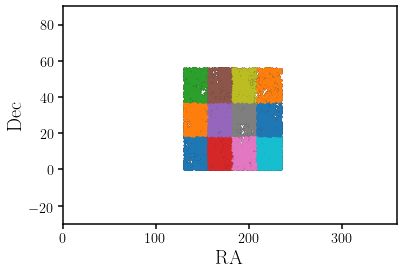

In [10]:
plt.scatter(nsa.data['ra'], nsa.data['dec'], c='k', s=1)
for field in jk_fields: 
    plt.scatter(nsa.data['ra'][field], nsa.data['dec'][field], s=1)
plt.xlabel('RA', fontsize=20)
plt.xlim(0., 360)
plt.ylabel('Dec', fontsize=20)
plt.ylim(-30, 90)

In [11]:
jk_phis = [] 
for field in jk_fields: 
    _Ngal, _ = np.histogram(nsa.data['log.M_star'][~field], bins=logms_bin) 
    _phi = _Ngal.astype(float) / vol_nsa / dlogms
    jk_phis.append(_phi)

n_jk = len(jk_phis)
jk_avg_phi = np.sum(np.array(jk_phis), axis=0)/float(n_jk)
phi_err_jk = np.sqrt(float(n_jk-1)/float(n_jk)*np.sum(np.array([(_phi - jk_avg_phi)**2 for _phi in jk_phis]), axis=0))

(5e-05, 0.02)

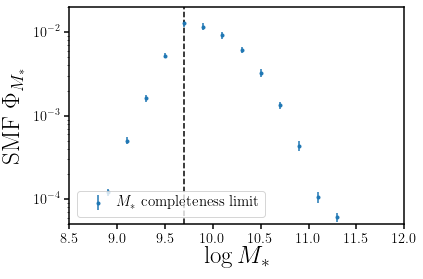

In [12]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.errorbar(0.5*(logms_bin[1:] + logms_bin[:-1]), phi_nsa, yerr=phi_err_jk, 
             fmt='.C0', label='$M_*$ completeness limit')
sub.legend(loc='lower left', frameon=True, handletextpad=0.2, fontsize=15)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(8.5, 12.)
sub.set_ylabel(r'SMF $\Phi_{M_*}$', fontsize=25)
sub.set_yscale("log")
sub.set_ylim(5e-5, 2e-2)
ylim = sub.get_ylim()
sub.plot([9.7, 9.7], ylim, c='k', ls='--')
sub.set_ylim(ylim)

In [13]:
f_phi = os.path.join(os.environ['GALPOPFM_DIR'], 'obs', 'nsa.Mr19.5.smf.dat') 
np.savetxt(f_phi, np.array([logms_bin[:-1], logms_bin[1:], phi_nsa, phi_err_jk]).T)